In [27]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split

In [28]:
#差分方程  # 生成数据
def nonlinear_system(y1_k, y2_k, u1_k, u2_k, u1_k_1, u2_k_1):
    # 生成噪声
    noise_level = 0.01
    noise1 = np.random.normal(loc=0, scale=np.sqrt(noise_level))
    noise2 = np.random.normal(loc=0, scale=np.sqrt(noise_level))
    # 计算输出
    output1 = y1_k / (1 + y2_k**2) + u1_k + 0.2 * u2_k + 0.4 * u1_k_1 + 0.1 * u2_k_1 + noise1
    output2 = y1_k * y2_k / (1 + y2_k**2) + 0.3 * u1_k + u2_k + 0.1 * u1_k_1 + 0.5 * u2_k_1 + noise2
    return output1, output2


# 参数设置
num_samples = 300
y1_data, y2_data = np.zeros(num_samples), np.zeros(num_samples)

# 初始化初始条件
y1_data[0], y2_data[0] = 1.0, 0.5

# 生成输入数据在[-1, 1]之间
u1_data = np.random.uniform(-1, 1, num_samples)
u2_data = np.random.uniform(-1, 1, num_samples)
u1_data_1 = np.roll(u1_data, 1)
u2_data_1 = np.roll(u2_data, 1)
u1_data_1[0], u2_data_1[0] = 0, 0  # 设置第一个时刻的上一个时刻输入为0

# 生成数据
for k in range(1, num_samples):
    y1_data[k], y2_data[k] = nonlinear_system(y1_data[k-1], y2_data[k-1], u1_data[k], u2_data[k], u1_data_1[k], u2_data_1[k])

print()

In [29]:
#组合训练数据  多输入单输出
# 假设有训练数据 u1_data, u2_data, y1_data_1 和 y1_data
# 将它们组合成输入特征矩阵 X 和输出标签向量 y
u1_data_1 = np.roll(u1_data, 1)
u2_data_1 = np.roll(u2_data, 1)
u1_data_1[0], u2_data_1[0] = 0, 0
y1_data_1 = np.roll(y1_data, 1)
y1_data_1[0] = 0.3
X = np.column_stack((u1_data, u2_data, u1_data_1, u2_data_1, y1_data_1))
y = y1_data
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3333, random_state=42)


In [30]:
# 训练模型
def model_train(params,X_train, y_train,K_train):
    C ,gamma= params
    
    # 定义 LS-SVR 的目标函数
    def objective(W, X, y, C): 
        
        # print(K.shape)
        # print(W.shape)
        y_pred = np.dot(K_train, W[:-1]) + W[-1]
        # y_pred = np.dot(X, W)
        errors = y - y_pred
        # 损失函数
        loss = 0.5 * np.dot(W, W) + C * np.sum(errors**2)
        return loss
    # 初始化权重向量
    initial_W = np.zeros(X_train.shape[0] + 1)
    # 使用minimize 函数最小化目标函数
    result = minimize(objective, initial_W, args=(X_train, y_train, C),
                        method='L-BFGS-B')
    # print(result)
    # 输出最优的权重向量
    best_W = result.x

    return best_W

In [31]:
Times = 20

In [33]:
# 定义优化目标函数：输入params，输出mse
def objective(params):

    C ,gamma= params
    K_train = rbf_kernel(X_train, X_train, gamma=gamma) 
    K_test = rbf_kernel(X_test, X_train, gamma=gamma) 

    # 训练模型 输入C ,gamma，输出 best_W
    best_W = model_train(params, X_train, y_train,K_train)
    # 模型预测      
    y_pred = np.dot(K_test, best_W[:-1]) + best_W[-1]
    
    # y_pred = np.dot(X_test, best_W)
    # 定义适应度函数
    mse = mean_squared_error(y_test, y_pred)
    # print(f'Mean Squared Error: {mse}')
    return mse


# 定义参数搜索空间
space = [(0.1, 120.0, 'log-uniform'),  # C范围为[0.1, 100]的对数均匀分布
        (0.001, 10.0, 'log-uniform')]  # gamma范围为[0.01, 10]的对数均匀分布
# 使用粒子群算法进行参数优化
result = gp_minimize(objective, space, n_calls=Times, random_state=42)
# 输出最优参数params
best_params = result.x
print(f"Best Parameters (C, gamma): {best_params}")



## 使用最优参数params训练模型
C ,gamma= best_params
K_train = rbf_kernel(X_train, X_train, gamma=gamma) 
K_test = rbf_kernel(X_test, X_train, gamma=gamma) 

best_W = model_train(best_params, X_train, y_train,K_train)
# 在测试集上进行预测
y_pred11 = np.dot(K_test, best_W[:-1]) + best_W[-1]
# y_pred = np.dot(X_test, best_W)
# 评估最终模型的性能
mse = mean_squared_error(y_test, y_pred11)
print(f'Mean Squared Error with Optimized Parameters: {mse}')

Best Parameters (C, gamma): [24.694596095167302, 0.017416230478996167]
Mean Squared Error with Optimized Parameters: 0.07585040937691907


In [14]:
# 定义优化目标函数
def objective(params):
    C, gamma = params
    svr = SVR(kernel='rbf', C=C, gamma=gamma)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# 定义参数搜索空间
space = [(0.1, 120.0, 'log-uniform'),  # C范围为[0.1, 100]的对数均匀分布
        (0.001, 10.0, 'log-uniform')]  # gamma范围为[0.01, 10]的对数均匀分布

# 使用粒子群算法进行参数优化
result = gp_minimize(objective, space, n_calls=Times, random_state=42)

# 输出最优参数
best_params = result.x
print(f"Best Parameters (C, gamma): {best_params}")

# 在最优参数下重新训练模型
best_C, best_gamma = best_params
best_svr = SVR(kernel='rbf', C=best_C, gamma=best_gamma)
best_svr.fit(X_train, y_train)

# 在测试集上进行预测
y_pred22 = best_svr.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred22)
print(f'Mean Squared Error with Optimized Parameters: {mse}')

Best Parameters (C, gamma): [77.62004675928509, 0.0010071984838809192]
Mean Squared Error with Optimized Parameters: 0.06757704634521526


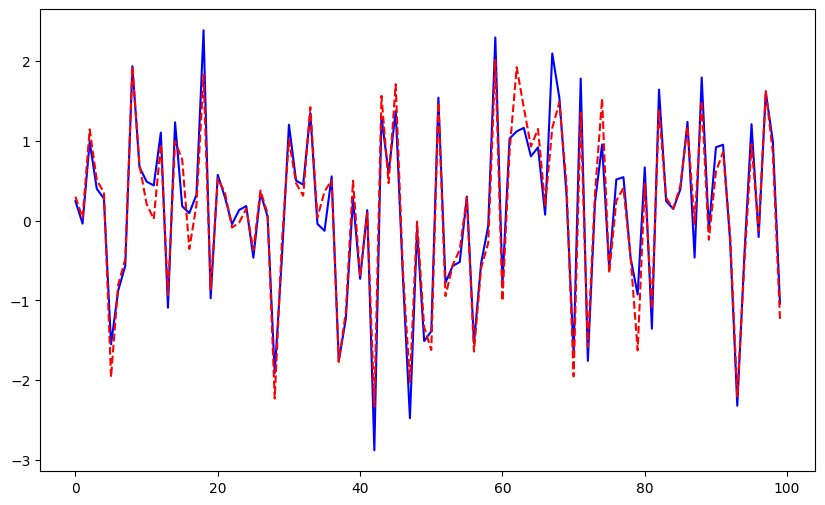

In [15]:
plt.figure(figsize=(10, 6))  
plt.plot(y_test,'b-')
plt.plot(y_pred11,'r--')
# plt.plot(y_pred22,'g--')

In [16]:
# 构成训练数据，假设X{u1_data、u2_data、y1_data_1 } 是输入特征，Y{y1_data} 是输出标签
u1_data_1 = np.roll(u1_data, 1)
u2_data_1 = np.roll(u2_data, 1)
u1_data_1[0], u2_data_1[0] = 0, 0  # 设置第一个时刻的上一个时刻输入为0
y1_data_1 = np.roll(y1_data, 1)
y2_data_1 = np.roll(y2_data, 1)
y1_data_1[0], y2_data_1[0] = 0.5, 0.5  # 设置第一个时刻的上一个时刻输入为0.5
X = np.column_stack((u1_data, u2_data, u1_data_1, u2_data_1, y1_data_1, y2_data_1))
y = np.column_stack((y1_data,y2_data))

In [17]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 假设 X 包含 u1_data、u2_data、y1_data_1、y2_data_1
# Y 包含 y1_data、y2_data
# 请确保 X 和 Y 的形状匹配

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3333, random_state=42)

# 定义优化目标函数
def objective(params):
    C, gamma = params
    svr = SVR(kernel='rbf', C=C, gamma=gamma)
    multioutput_svr = MultiOutputRegressor(svr)  # 使用MultiOutputRegressor包装SVR
    multioutput_svr.fit(X_train, y_train)
    y_pred = multioutput_svr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# 定义参数搜索空间
# 定义参数搜索空间
space = [(0.1, 200.0, 'log-uniform'),  # C范围为[0.1, 100]的对数均匀分布
        (0.001, 10.0, 'log-uniform')]  # gamma范围为[0.01, 10]的对数均匀分布

# 使用粒子群算法进行参数优化
result = gp_minimize(objective, space, n_calls=20, random_state=42)

# 输出最优参数
best_params = result.x
print(f"Best Parameters (C, gamma): {best_params}")

# 在最优参数下重新训练模型
best_C, best_gamma = best_params
best_svr = SVR(kernel='rbf', C=best_C, gamma=1)
multioutput_best_svr = MultiOutputRegressor(best_svr)
multioutput_best_svr.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = multioutput_best_svr.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error with Optimized Parameters: {mse}')


Best Parameters (C, gamma): [200.0, 0.07893333003412858]
Mean Squared Error with Optimized Parameters: 0.13084752351480092


In [18]:
mse = mean_squared_error(y_test[:,0], y_pred[:,0])
print(f'Mean Squared Error with Optimized Parameters: {mse}')
mse = mean_squared_error(y_test[:,1], y_pred[:,1])
print(f'Mean Squared Error with Optimized Parameters: {mse}')

Mean Squared Error with Optimized Parameters: 0.13807168615397092
Mean Squared Error with Optimized Parameters: 0.12362336087563089


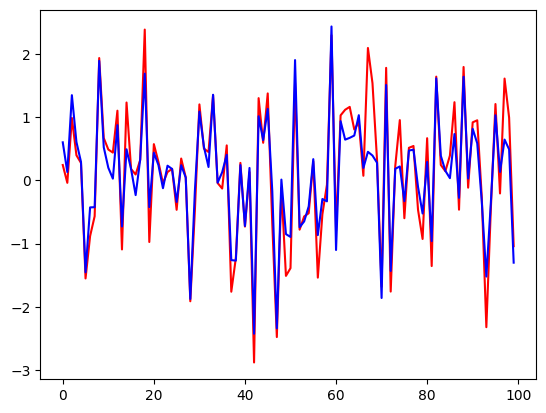

In [19]:
plt.plot(y_test[:,0],'r-')
plt.plot(y_pred[:,0],'b-')

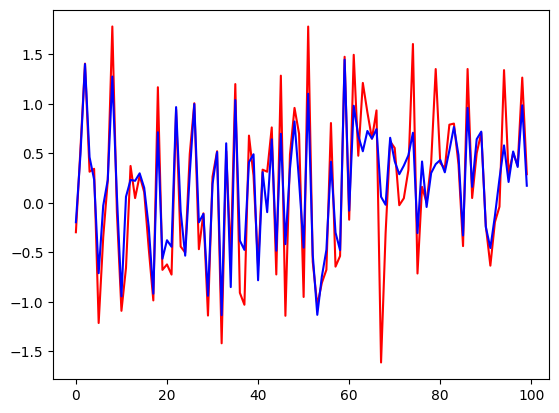

In [20]:
plt.plot(y_test[:,1],'r-')
plt.plot(y_pred[:,1],'b-')